In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min width:70px;}
div#toc-wrapper {padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe {font-size:12px;}
</style>
"""))

- red wine 품질 등급 에측

```
1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler)
    ->타겟변수 원핫인코딩(get_dummies)-> 훈련셋과 테스트셋분리(train_test_split)
2. 모델 구성 (입력 11, 출력 ?)
3. 모델학습과정 설정(다중분류로 설정)
4. 모델학습(callbacks 이용)
5. 모델평가 - 그래프, 평가(테스트셋), 교차표/혼동행렬
6. 모델 저장 /사용
```

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

# 1. 데이터셋 확보 & 전처리
- 독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler) ->타겟변수 원핫인코딩(get_dummies)-> 훈련셋과 테스트셋분리(train_test_split)

In [3]:
# 데이터 읽어오기
# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


- 데이터 열 설명

```
fixed acidity (고정 산도): 주로 주석산 농도를 나타냅니다.
volatile acidity (휘발성 산도): 아세트산 농도를 나타내며, 높을수록 와인의 향에 부정적인 영향을 줄 수 있습니다.
citric acid (구연산): 와인에 신선함을 더하는 역할을 합니다.
residual sugar (잔류 당분): 발효 후 남은 설탕의 양으로, 와인의 단맛에 기여합니다.
chlorides (염화물): 와인의 짠맛과 관련이 있습니다.
free sulfur dioxide (유리 이산화황): 와인을 오래 보관하게 하는 방부제 역할을 합니다.
total sulfur dioxide (총 이산화황): 유리 이산화황을 포함한 전체 이산화황의 양입니다.
density (밀도): 알코올 도수 및 당도와 관련이 있습니다.
pH: 산도(acidity) 수준을 나타냅니다.
sulphates (황산염): 와인의 황 함량을 나타내며, 방부 및 항산화 작용을 합니다.
alcohol (알코올): 와인의 알코올 도수입니다.
quality (품질): 전문가가 평가한 최종 품질 점수 (0~10점). 
```

In [6]:
redwine.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
#타겟변수의 균형 (불균등)
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
#독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사, numpy 배열로
y_redwine = redwine.iloc[:, -1]
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [7]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaled_X_redwine = scaler.fit_transform(X_redwine)
# 다중분류를 위한 원핫인코딩 -> numpy 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()


In [6]:
# 독립변수, 종속변수
scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [9]:
print('원데이터 -> 원핫인코딩')
# 원핫인콬딩한 0번째 인덱스가 3등급(get_dummies()사용)
np.column_stack([y_redwine[3:5], Y_redwine[3:5]])

원데이터 -> 원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [10]:
# 훈련셋과 테스트셋 분리 (층화추출)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine, Y_redwine, train_size=0.7, stratify=Y_redwine)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [15]:
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),
    pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
    pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 모델 구성 (입력11, 출력6)

In [34]:
model = Sequential()
model.add(Input(shape=11))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                600       
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 30)                1530      
                                                                 
 dense_8 (Dense)             (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습과정 설정(다중분류에 맞는 설정)
# 4. 학습시키기(callbacks 이용)

In [35]:
%%time
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end() 함수가 epoch 수행후 자동 호출
    def __init__(self):
        self.epoch = 0;
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5==0)| (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'.format(self.epoch, logs.get('loss'), 
                                                                                        logs.get('accuracy'), 
                                                                                        logs.get('val_loss'), 
                                                                                        logs.get('val_accuracy')))
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder +'wine_{epoch:03d}_loss_{val_loss:.4f}_acc{val_accuracy:.4f}.h5'

customHistory = CustomHistory()
checkpoint = ModelCheckpoint(filepath=file, monitor='val_accuracy', save_best_only=True, mode = 'max', verbose=0)
earlyStopping = EarlyStopping(patience=20)
#학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200, validation_split=0.2, verbose=0,
                callbacks=[earlyStopping, customHistory, checkpoint])

1번째 loss:2.1886, acc:0.0492, val_loss:1.9587, val_acc:0.0714
5번째 loss:1.6239, acc:0.4335, val_loss:1.5664, val_acc:0.4955
10번째 loss:1.1929, acc:0.5777, val_loss:1.2155, val_acc:0.5357
15번째 loss:1.0555, acc:0.5978, val_loss:1.1148, val_acc:0.5536
20번째 loss:1.0207, acc:0.5855, val_loss:1.0912, val_acc:0.5580
25번째 loss:0.9654, acc:0.6223, val_loss:1.0821, val_acc:0.5446
30번째 loss:0.9477, acc:0.6078, val_loss:1.0756, val_acc:0.5536
35번째 loss:0.9219, acc:0.6324, val_loss:1.0549, val_acc:0.5536
40번째 loss:0.9025, acc:0.6324, val_loss:1.0494, val_acc:0.5670
45번째 loss:0.8882, acc:0.6391, val_loss:1.0356, val_acc:0.5670
50번째 loss:0.8589, acc:0.6425, val_loss:1.0316, val_acc:0.5714
55번째 loss:0.8529, acc:0.6480, val_loss:1.0299, val_acc:0.5759
60번째 loss:0.8486, acc:0.6346, val_loss:1.0357, val_acc:0.5848
65번째 loss:0.8250, acc:0.6682, val_loss:1.0250, val_acc:0.5982
70번째 loss:0.8181, acc:0.6648, val_loss:1.0267, val_acc:0.5982
75번째 loss:0.8022, acc:0.6603, val_loss:1.0220, val_acc:0.5938
80번째 loss:

# 5. 모델 평가
- 학습과정 시각화, 평가(테스트셋), 교차표(혼동행렬)


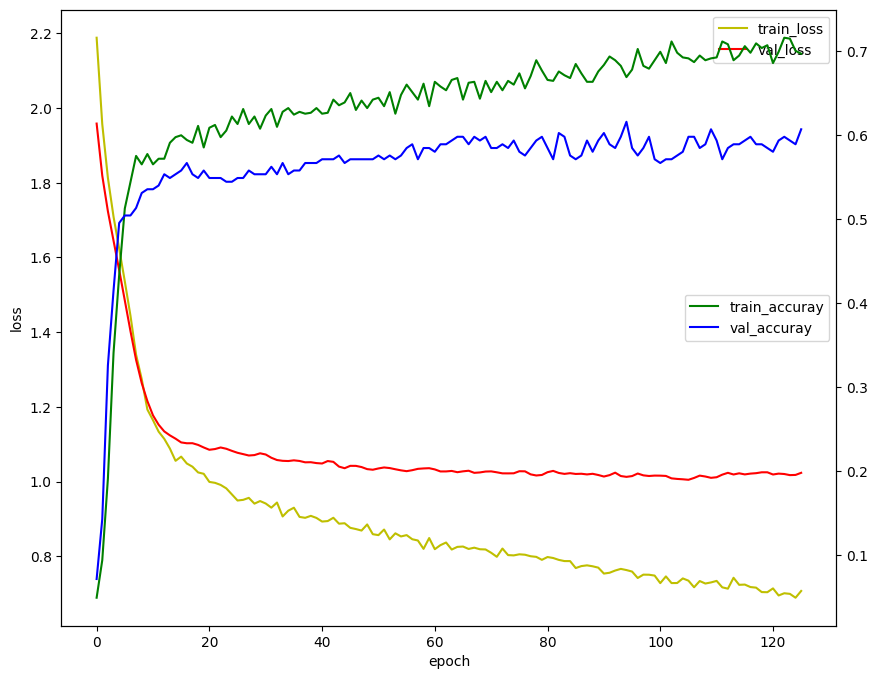

In [36]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,8))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x 축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuray')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuray')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='upper right')
acc_ax.legend(loc='center right')
plt.show()

In [37]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:1.0676, accuracy:0.6104


In [38]:
model1 = load_model('model/wine_095_loss_1.0125_acc0.6161.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:1.0392, accuracy:0.6104


In [39]:
model1.save('model/wine.h5')

In [43]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1)+3 # 실제값
pred = model.predict(X_test).argmax(axis=1)+3
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 960us/step


predict,4,5,6,7
real,,,,
3,1,1,1,0
4,1,10,5,0
5,3,148,52,1
6,0,59,126,7
7,0,4,38,18
8,0,0,4,1


# 6. 모델저장

In [44]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [47]:
input_data = [7.4, 0.7, 0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 17ms/step


array([5], dtype=int64)